##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [4]:
#run "pip install -r requirements.txt" in terminal
import numpy as np
#run "pip install tensorflow_datasets" in terminal (or put it in the requirements.txt)
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

/home/coder/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-15 09:52:51.458386: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Import `matplotlib` and create a helper function to plot graphs:

In [5]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric): # defining a function which takes two arguments
  plt.plot(history.history[metric]) # the history object can be used to plot whatever metrix you want to show the output
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs") # gives x-axis a name
  plt.ylabel(metric) #gives y-axis a name
  plt.legend([metric, 'val_'+metric]) # create legend

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [6]:
#loading data set and dividing into a training and a test set
dataset, info = tfds.load('imdb_reviews', with_info=True, # load data
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test'] # split into train and test

train_dataset.element_spec

2023-03-15 10:13:22.188154: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dataset imdb_reviews downloaded and prepared to /home/coder/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


2023-03-15 10:14:00.364554: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [11]:
for example, label in train_dataset.take(1): # we take 1 example from the training data
  print('text: ', example.numpy()) # from that example we want to print text ...
  print('label: ', label.numpy()) # ... and the label.

# label 0 is negative, and label 1 is positive

text:  [b'Well, there is a plenty of ways how to spoil a political thriller. Usually they are derivative or too ambitious, often they feature a conspiracy that is totally paranoic and unbelievable. But City Hall does not do neither of the above mentioned. The plot is cleverly crafted, story is believable. As far as characters go I would say this movie is a solid average. No character seems out of place and Al Pacino is brilliant as always. His portrayal of a charismatic NYC mayor is superb and proves again that Al Pacino belongs to the absolute top of American actors nowadays.'
 b"Having heard so many people raving about this film I thought I'd give it a go. Apart from being incredibly slow, which I don't mind as long as the wait is worth it, but it just isn't. As many others have said there are so many inconsistencies and so much of this film just doesn't ring true. The reaction of the 4 men switches from shock, horror on finding the body to complete indifference whilst they fish. Sur

2023-03-15 10:25:30.068048: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [8]:
BUFFER_SIZE = 10000 
# the buffer is the number of documents which are pulled out from the whole data set, shuffled and used to train the model. 
# each time the model trains on one of the 10000 documents, this document is then "thrown out" and a new document from the complete data set is picked to be part of the buffer of 10000 documents. 
# we do this to same time and computational memory. 
BATCH_SIZE = 64 
# the number of examples which the model takes from the buffer, trains on and then throws away (and then it takes 64 new docs from the main data set and pull to the buffer)
# the model only update the weights after seeing 64 examples. To the model learns from a batch of data instead of from individual data points. Less change of data overfedding. 
# Think of Ross' example of the cards with cats and dogs. 

In [10]:
# take 10000 examples from the train and the test set respectively, shuffle them and and pick 64.
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#.prefetch(tf.data.AUTOTUNE) is a finegrained optimizing thing, which we shouldn't think that much about. 

In [12]:
# show examples
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

# Notice that the data isn't super clean, it has some wierd signs and stuff. 

texts:  [b'I haven\'t watched the movie yet, but can\'t wait to see it! It seems very interesting and inspirational. It was one of the most interesting trailers I\'ve ever seen: the questions it posed really stopped me and made me think, the unique approach to the sport of boxing as a metaphor for the "battle within"... thank god somebody is hitting another angle with the boxing thing. This film looks so fresh and smart. And the actor is really hot. I especially enjoyed the short clip with the actor from the Rocky movies, really clever. I thought that the topic selected-overcoming adversities and childhood traumas-is timeless, and god knows a lot of people need it. Bring it on.'
 b'I remember Casper comic books, but don\'t remember any cartoons. Maybe they weren\'t memorable; I don\'t know but at my advanced age, here I am watching this very early Casper animated short yesterday. Afterward, I was shocked to read the user-comments here. Did people miss the ending?<br /><br />I have to l

2023-03-15 10:40:01.439910: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [13]:
# reduces each document by keeping only the 10000 most frequent words from the document. 
# Document representation: Every document is reduced to a sequence of 10000 numbers where each number referes to a word. 
VOCAB_SIZE = 1000 
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [14]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20] # show the 20 first tokens (out of the 1000 picked out above)
# *blank space* is word number 1, [UNK] is word number 2, "the" is word number 3 etc.

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [15]:
encoded_example = encoder(example)[:3].numpy()
encoded_example
# now the text is represented by numbers so so e.g. 10 means "i" 
#the whole document are represented by numbers

array([[ 10, 731, 284, ...,   0,   0,   0],
       [ 10, 364,   1, ...,   0,   0,   0],
       [ 11,  20,  14, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [16]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'I haven\'t watched the movie yet, but can\'t wait to see it! It seems very interesting and inspirational. It was one of the most interesting trailers I\'ve ever seen: the questions it posed really stopped me and made me think, the unique approach to the sport of boxing as a metaphor for the "battle within"... thank god somebody is hitting another angle with the boxing thing. This film looks so fresh and smart. And the actor is really hot. I especially enjoyed the short clip with the actor from the Rocky movies, really clever. I thought that the topic selected-overcoming adversities and childhood traumas-is timeless, and god knows a lot of people need it. Bring it on.'
Round-trip:  i havent watched the movie yet but cant wait to see it it seems very interesting and [UNK] it was one of the most interesting [UNK] ive ever seen the [UNK] it [UNK] really [UNK] me and made me think the unique [UNK] to the [UNK] of [UNK] as a [UNK] for the battle within [UNK] god [UNK] is [UNK] a

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [17]:
# creating the neural network
model = tf.keras.Sequential([ #define model
    encoder,# encoder layer
    tf.keras.layers.Embedding( # embedding layer
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), # bi-directional layer
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [18]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [19]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[-0.00922541]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [20]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 229ms/step
[-0.00922541]


Compile the Keras model to configure the training process:

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [22]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)
#this takes a LOOOONG of time (det tog 40 min), because we are looking at all the individual words. 

Epoch 1/10
391/391 [==============================] - 247s 617ms/step - loss: 0.6531 - accuracy: 0.5381 - val_loss: 0.5396 - val_accuracy: 0.6781
Epoch 2/10


2023-03-15 10:50:21.896586: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 234s 600ms/step - loss: 0.4160 - accuracy: 0.8027 - val_loss: 0.3679 - val_accuracy: 0.8333
Epoch 3/10


2023-03-15 10:54:16.411597: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 236s 604ms/step - loss: 0.3437 - accuracy: 0.8482 - val_loss: 0.3462 - val_accuracy: 0.8469
Epoch 4/10


2023-03-15 10:58:12.684881: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 236s 603ms/step - loss: 0.3257 - accuracy: 0.8590 - val_loss: 0.3423 - val_accuracy: 0.8516
Epoch 5/10


2023-03-15 11:02:08.515304: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 236s 603ms/step - loss: 0.3143 - accuracy: 0.8648 - val_loss: 0.3266 - val_accuracy: 0.8599
Epoch 6/10


2023-03-15 11:06:04.369754: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 239s 612ms/step - loss: 0.3097 - accuracy: 0.8663 - val_loss: 0.3334 - val_accuracy: 0.8604
Epoch 7/10


2023-03-15 11:10:03.761661: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 238s 608ms/step - loss: 0.3057 - accuracy: 0.8682 - val_loss: 0.3250 - val_accuracy: 0.8526
Epoch 8/10


2023-03-15 11:14:01.388138: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 237s 606ms/step - loss: 0.3031 - accuracy: 0.8694 - val_loss: 0.3254 - val_accuracy: 0.8625
Epoch 9/10


2023-03-15 11:17:58.500764: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 238s 607ms/step - loss: 0.3007 - accuracy: 0.8694 - val_loss: 0.3333 - val_accuracy: 0.8594
Epoch 10/10


2023-03-15 11:21:56.210612: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 236s 605ms/step - loss: 0.2996 - accuracy: 0.8707 - val_loss: 0.3263 - val_accuracy: 0.8536


2023-03-15 11:25:52.710232: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 75s 193ms/step - loss: 0.3202 - accuracy: 0.8586
Test Loss: 0.32017743587493896
Test Accuracy: 0.8586400151252747


(0.0, 0.6708109647035598)

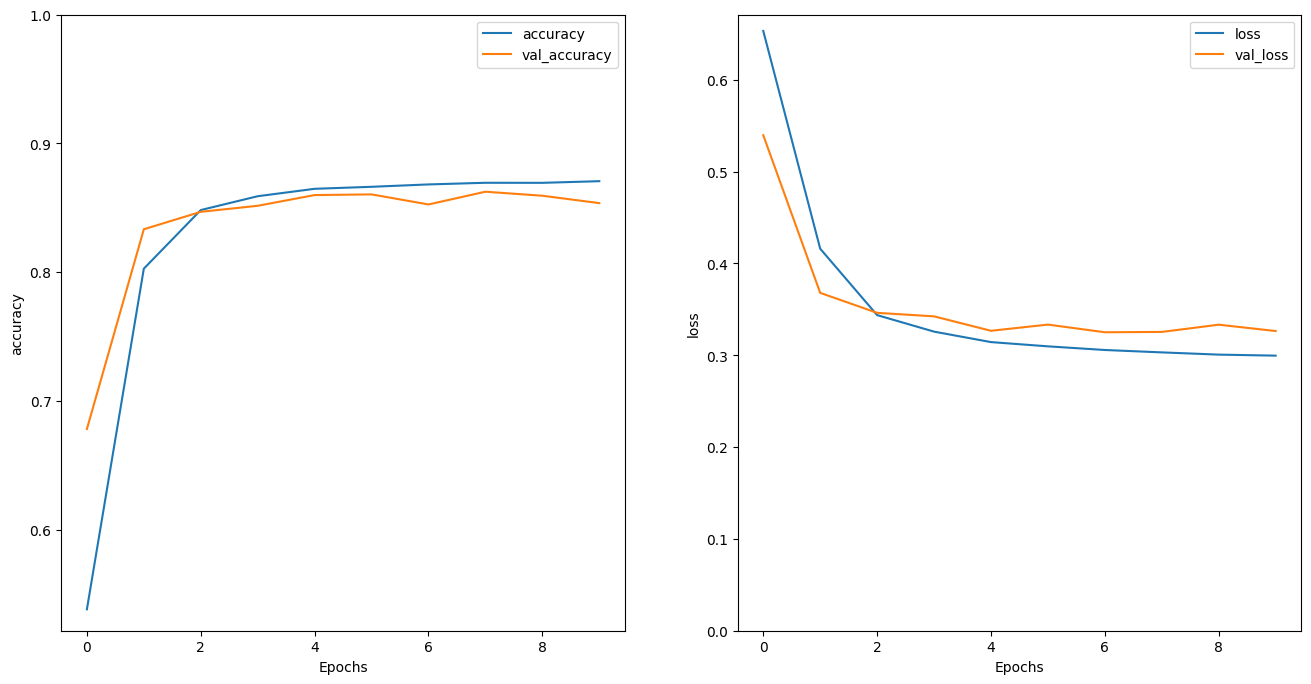

In [24]:
# plotting
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [25]:
#use the model to make predictions on new data
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
